In [111]:
import pandas as pd 
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from math import floor

import matplotlib.style
import matplotlib as mpl

plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')

mpl.rcParams['savefig.dpi'] = 300

verbose = False

# Dane pojazdu

In [112]:
m_0=850	# masa własna[kg]
m=1260	# DMC [kg]
A=1.93	# m^2
c_x=0.35  
f_0=0.01

# masa własna + paliwo + kierowca
# m=m_0 + 75 + 720*40/1000

i_g=4.06

i_1=3.37
i_2=1.86
i_3=1.32
i_4=0.97
i_5=0.76

# macierz przełożeń biegów
gear_i = pd.Series()
gear_i['1']=3.37
gear_i['2']=1.86
gear_i['3']=1.32
gear_i['4']=0.97
gear_i['5']=0.76

# charakterystyka silnika D4F pobrana z pliku .csv wygenerowanego na bazie obrazu charakterystyki
char_silnika = pd.read_csv('char_silnika.csv')
char_silnika.P = char_silnika.P * 0.735

# sprawność układów mechanicznych
eta_M=0.9

# moc i moment maksymalne (wyznaczone na bazie charakterystyki silnika)
P_s=np.max(char_silnika.P)	# kW
n_P = int(char_silnika.nP[char_silnika.P == P_s])	# obr/min
M_s = np.max(char_silnika.M)
n_M= 3650	# obr/min

w = 155
prof = 65
R_in = 14
R_mm = round(R_in * 25.4)

r_d = 0.97 * (w * prof / 100 + R_mm/2)
r_d = round(r_d)

g = 9.81 # m/s^2

## Charakterystyka Silnika D4F

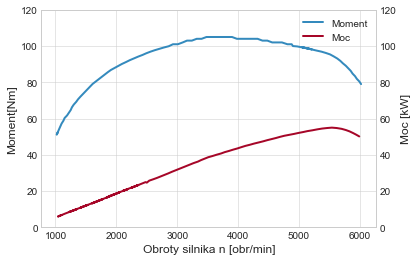

In [113]:
fig, ax = plt.subplots()

ax.plot(char_silnika.nM, char_silnika.M,
    label = 'Moment')

ax.plot(char_silnika.nP, char_silnika.P,
    label = 'Moc')

# ax.plot(n_P, P_s,
#     label = 'Moc maksymalna')

ax.set_yticks(range(0, 125, 20))

secaxy = ax.secondary_yaxis('right')

ax.set_xlabel('Obroty silnika n [obr/min]')
ax.set_ylabel('Moment[Nm]')
secaxy.set_ylabel('Moc [kW]')

ax.legend()
if verbose:  fig.savefig('images/char_silnika.png')

# Obliczenia
$ F_t = f_0 * mg(1 + v^2 * g*10^{-5}) $

In [114]:
df = pd.DataFrame()

# opory toczenia

# funkcja obliczająca Ft
def Ft(v, m=m):
    return m * g * f_0 * (1 + (v**2) * 5 * 10**(-5))

v_range = range(0,181, 10)


# tworzenie przebiegów Ft dla masy własnej i DMC w zakresie prędkości 0-181 km/h, zapis w macierzy df
df['Ft_m0'] = [Ft(v, m_0) for v in v_range]
df['Ft_m'] = [Ft(v) for v in v_range]

# dodanie kolumny prędkości do macierzy df
df['v'] = [v for v in v_range]

df

,Ft_m0,Ft_m,v
0,83.385000,123.60600,0
1,83.801925,124.22403,10
2,85.052700,126.07812,20
3,87.137325,129.16827,30
4,90.055800,133.49448,40
5,93.808125,139.05675,50
6,98.394300,145.85508,60
7,103.814325,153.88947,70
8,110.068200,163.15992,80
9,117.155925,173.66643,90


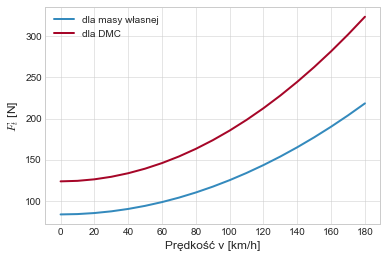

In [115]:
fig, ax = plt.subplots()

ax.plot(df.v, df.Ft_m0, 
    label = 'dla masy własnej')
ax.plot(df.v, df.Ft_m,
    label = 'dla DMC')

ax.set_ylabel('$F_t$ [N]')
ax.set_xlabel('Prędkość v [km/h]')
ax.set_xticks(range(0,181, 20))

ax.legend()


if verbose:  fig.savefig('images/plot_Ft.png')

## 1.2. Opory powietrza w funkcji prędkości

In [116]:

# funkcja obliczające Fp
def Fp(v):
    return 0.047 * A * c_x * v**2

# stworzenie kolumny Fp z wartościami funkcji Fp dla prędkości z zakresu 0-180 km/h i zapis w macierzy df
df['Fp'] = Fp(df.v)

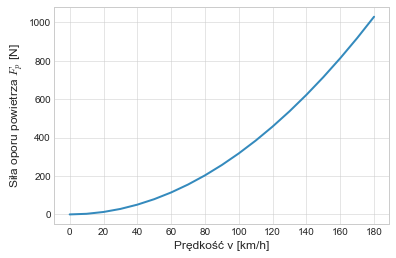

In [117]:
fig, ax = plt.subplots()

ax.plot(df.v, df.Fp, 
    label = '')

ax.set_ylabel('Siła oporu powietrza $F_p$ [N]')
ax.set_xlabel('Prędkość v [km/h]')
ax.set_xticks(range(0,191, 20))

# ax.legend()


if verbose:  fig.savefig('images/plot_Fp.png')

## 1.3. siła i moc oporów ruchu

In [118]:
# obliczenie F_op i P_op oraz zapis
df['F_op'] = df.Ft_m + df.Fp
df['P_op'] = df.F_op * df.v / 3600

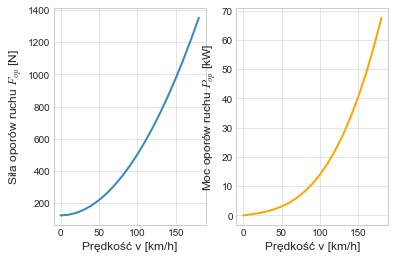

In [119]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(df.v, df.F_op, label='Fop [N]')
ax1.set_ylabel('Siła oporów ruchu $F_{op}$ [N]')
ax1.set_xlabel('Prędkość v [km/h]')

ax2.plot(df.v, df.P_op, label='Pop [kW]', color='orange')
ax2.set_ylabel('Moc oporów ruchu $P_{op}$ [kW]')
ax2.set_xlabel('Prędkość v [km/h]')

plt.savefig('images/plot_FopPop.png')


## 3. Charakterystyka Trakcyjna

In [120]:

# zapis macierzy df do nowej macierzy opory
opory = df

# lista macierzy charakterystyk trakcyjnych dla poszczególynch biegów
traction_char = [] 

# dla każdego biegu wylicz wartości Fn i Ps oraz prędkości na bazie n_s -> vM (dla momentu), vP (dla mocy)
for i in gear_i:
    df = pd.DataFrame()

    df['Fn'] = char_silnika.M * i_g * i * eta_M / r_d *1000
    df['vM'] = char_silnika.nM * r_d / (2.65 * i_g * i) / 1000
    df['vP'] = char_silnika.nP * r_d / (2.65 * i_g * i) / 1000
    df['Ps'] = char_silnika.P
    df['ib'] = i

    traction_char.append(df)


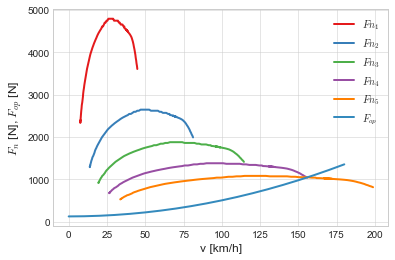

In [121]:
fig, ax = plt.subplots()

colors = plt.get_cmap('Set1')

for char, i in zip(traction_char, range(len(traction_char))):
    ax.plot(char.vM, char.Fn, 
        label='$Fn_{}$'.format(i+1),
        color = colors(i))

ax.plot(opory.v, opory.F_op, label='$F_{op}$')

char = traction_char[4]

ax.set_xlabel('v [km/h]')
ax.set_ylabel('$F_n$ [N], $F_{op}$ [N]')
ax.legend()

if verbose:  fig.savefig('images/plot_traction_char.png')

## Bilans mocy

In [122]:
# dla każdego biegu obliczenie bilansu mocy
for bieg in traction_char:
    bieg['P_k'] = bieg.Ps * eta_M


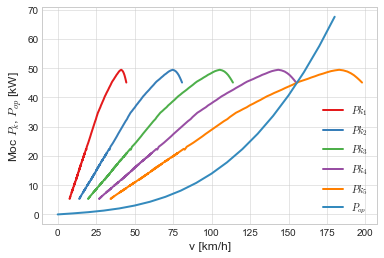

In [123]:
fig, ax = plt.subplots()

colors = plt.get_cmap('Set1')

for char, i in zip(traction_char, range(len(traction_char))):
    ax.plot(char.vP, char.P_k, 
        label='$Pk_{}$'.format(i+1),
        color = colors(i))

ax.plot(opory.v, opory.P_op, label='$P_{op}$')

ax.set_xlabel('v [km/h]')
ax.set_ylabel('Moc $P_k$, $P_{op}$ [kW]')
ax.legend()

if verbose:  fig.savefig('images/plot_bilans_mocy.png')

## Wskaźnik dynamiczny

In [124]:
# wskaźnik dynamiczny D = fn - fp / mg
for bieg in traction_char:
    bieg ['D'] = (bieg.Fn - Fp(bieg.vM)) / ( m * g)

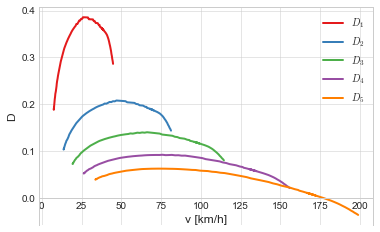

In [125]:
fig, ax = plt.subplots()

colors = plt.get_cmap('Set1')

for char, i in zip(traction_char, range(len(traction_char))):
    ax.plot(char.vM, char.D, 
        label='$D_{}$'.format(i+1),
        color = colors(i))

ax.set_xlabel('v [km/h]')
ax.set_ylabel('D')
ax.legend()
ax.axhline(linewidth=0.5, color='black')
ax.spines['bottom'].set_position('zero')

if verbose:  fig.savefig('images/plot_char_dynam.png')

## Charakterystyka przyśpieszeń

In [126]:
# dobór bezwładności mas wirujących
# moment bezwłasności mas wirujących silnika
Js = 0.1 # kg m^2

# moment bezwałdności koła 
Jk = 0.4 # kg m^2

# macierz pomocnicza parametrów bezwładności
iner = pd.Series()

iner['Jk'] = Jk
iner['Js'] = Js
iner['dk'] = 4 * Jk / (m * (r_d/1000)**2)
iner['ds'] = Js * i_g**2 * eta_M / (m * (r_d/1000)**2)

iner

Jk    0.400000
Js    0.100000
dk    0.017419
ds    0.016151
dtype: float64

In [127]:
# macierz pomocnicza współczynników bezwładności dla poszczególnych biegów
d_b = 1 + iner.ds * gear_i**2 + iner.dk
d_b

1    1.200843
2    1.073295
3    1.045560
4    1.032615
5    1.026748
dtype: float64

In [128]:
# obliczenie wartości przyśpieszeń oraz zapis do kolumny 'a' w macierzy biegu
for bieg, d_bi in zip(traction_char, d_b):
    ft = f_0 * (1 + (bieg.vM**2) * 5 * 10**(-5))
    bieg['a'] = (0.95 * bieg.D - ft) * g/d_bi

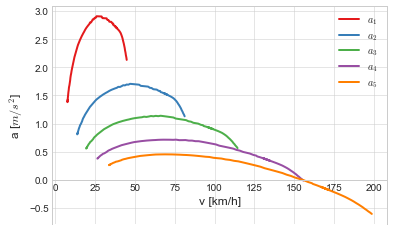

In [129]:
fig, ax = plt.subplots()

# TODO: poprawić oś x

colors = plt.get_cmap('Set1')

for char, i in zip(traction_char, range(len(traction_char))):
    ax.plot(char.vM, char.a, 
        label='$a_{}$'.format(i+1),
        color = colors(i))

ax.set_xlabel('v [km/h]')
ax.set_ylabel('a [$m/s^2$]')
ax.legend()
ax.axhline(linewidth=0.5, color='black')
ax.spines['bottom'].set_position('zero')

if verbose:  fig.savefig('images/plot_char_przysp.png')

## Charakterystyka rozpędzania

In [130]:
# dodawanie wiodących wartości do 1 biegu
bieg1 = traction_char[0]

# ilość punktów wiodących stałej prędkości
resolution = 15

# pobranie wiersza z macierzy 1 biegu z najmniejszą wartością przyśpieszenia
row = bieg1[bieg1.a == bieg1.a.min()]
row.vM, row.vP = 0, 0

# konwersja wiersza na słownik (ułatwienie manipulacji)
row = row.to_dict()
for key in row:
    row[key] = row[key][1]

# stworzenie list wartości prędkości i przyśpieszeń
a = [round(bieg1.a.min(), 2) for i in np.linspace(0, bieg1.vM.min(), resolution)]
v = np.linspace(0, bieg1.vM.min(), resolution)

# zmiana vM i vP oraz a na wartości wyliczone
new_rows = []
for vi, ai in zip(v, a):
    new_row = dict(row)
    new_row['vM'] = vi
    new_row['vP'] = vi
    new_row['a'] = ai

    new_rows.append(new_row)

# połączenie przedłużenia linii 1 biegu z jego macierzą
bieg1 = pd.concat([pd.DataFrame(new_rows), bieg1])
bieg1.reset_index(drop=True, inplace=True)

# nadpisanie biegu 1 w wektorze biegów
traction_char[0] = bieg1

In [131]:
# wyświetlenie wyenerowanych wierszy dla biegu 1 wszego
traction_char[0].head(resolution)

,Fn,vM,vP,Ps,ib,P_k,D,a
0,2330.534733,0.000000,0.000000,5.90205,3.37,5.311845,0.188397,1.38
1,2330.534733,0.542543,0.542543,5.90205,3.37,5.311845,0.188397,1.38
2,2330.534733,1.085086,1.085086,5.90205,3.37,5.311845,0.188397,1.38
3,2330.534733,1.627629,1.627629,5.90205,3.37,5.311845,0.188397,1.38
4,2330.534733,2.170172,2.170172,5.90205,3.37,5.311845,0.188397,1.38
5,2330.534733,2.712715,2.712715,5.90205,3.37,5.311845,0.188397,1.38
6,2330.534733,3.255257,3.255257,5.90205,3.37,5.311845,0.188397,1.38
7,2330.534733,3.797800,3.797800,5.90205,3.37,5.311845,0.188397,1.38
8,2330.534733,4.340343,4.340343,5.90205,3.37,5.311845,0.188397,1.38
9,2330.534733,4.882886,4.882886,5.90205,3.37,5.311845,0.188397,1.38


In [132]:
# macierz charakterystyki rozpędzania
char_rozp = pd.DataFrame({'dt': 0, 'dv': 0, 'v': 0, 't': 0}, index=[0])

# krok prędkości
dv = 10 # km/h

# czas zmiany biegu
dtb = 0.5  #s 

# zmienne przechowujące prędkość i czas
v = dv
t = 0

# TODO: sprawdzić jak będzie działało patrząc 'do przodu'

# dla każdego biegu
for bieg in traction_char:

    # dla prędkości do maksymalnej prędkości na biegu
    while v < bieg.vM.max():

        a_sr = np.mean(bieg.a[(bieg.vM >= v - dv) & (bieg.vM < v)])

        # jeśli średnia przyśpieszeń ujemna -> przerwij
        if(a_sr<0): break
        if(t>40): break

        # obliczenie odcinka czasu
        dt = dv / (3.6 * a_sr)

        v+=dv
        t += dt

        # zapis do macierzy 
        char_rozp = char_rozp.append({'dt': dt, 'dv': dv, 't': t, 'v': v}, ignore_index=True)

    # zapis zmiany biegu do macierzy
    t += dtb
    char_rozp = char_rozp.append({'dt': dtb, 'dv': 0, 't': t, 'v': v}, ignore_index=True)

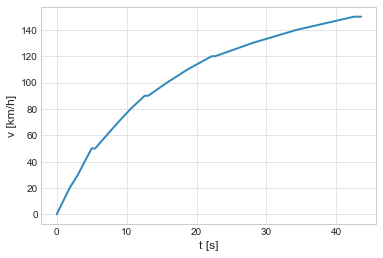

In [133]:
fig, ax = plt.subplots()

colors = plt.get_cmap('Set1')


ax.plot(char_rozp.t, char_rozp.v, 
    label='Charakterystyka rozpędzania')

ax.set_xlabel('t [s]')
ax.set_ylabel('v [km/h]')

if verbose:  fig.savefig('images/plot_char_rozp.png')

In [134]:
# wyliczenie czasu przyśpieszania do 50 km/h i 100 km/h

t_50 = char_rozp.t[char_rozp.v<=50].max()
t_100 = char_rozp.t[char_rozp.v<=100].max()

t_50 = round(t_50,2)
t_100 = round(t_100,2)
print(t_50, t_100)

5.5 15.78
